# 处理原始数据

In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import PercentFormatter

%matplotlib inline

In [2]:
# 读取 csv 原始数据

with open('data/power.csv') as f:
    csv_data = list(csv.reader(f))[1:]
    
len(csv_data)

885468

In [3]:
# 预览前 30 条数据

csv_data[:30]

[['2015/1/1', '1', '1135'],
 ['2015/1/2', '1', '570'],
 ['2015/1/3', '1', '3418'],
 ['2015/1/4', '1', '3968'],
 ['2015/1/5', '1', '3986'],
 ['2015/1/6', '1', '4082'],
 ['2015/1/7', '1', '4172'],
 ['2015/1/8', '1', '4022'],
 ['2015/1/9', '1', '4025'],
 ['2015/1/10', '1', '4047'],
 ['2015/1/11', '1', '4135'],
 ['2015/1/12', '1', '4111'],
 ['2015/1/13', '1', '3926'],
 ['2015/1/14', '1', '4244'],
 ['2015/1/15', '1', '4144'],
 ['2015/1/16', '1', '4269'],
 ['2015/1/17', '1', '4262'],
 ['2015/1/18', '1', '2782'],
 ['2015/1/19', '1', '3327'],
 ['2015/1/20', '1', '4002'],
 ['2015/1/21', '1', '3925'],
 ['2015/1/22', '1', '3813'],
 ['2015/1/23', '1', '4293'],
 ['2015/1/24', '1', '4205'],
 ['2015/1/25', '1', '4162'],
 ['2015/1/26', '1', '3917'],
 ['2015/1/27', '1', '4007'],
 ['2015/1/28', '1', '4060'],
 ['2015/1/29', '1', '4045'],
 ['2015/1/30', '1', '4162']]

In [4]:
# 获取 id 最大值

id_max = max([int(item[1]) for item in csv_data])
id_max

1454

In [5]:
# 清洗数据

cnt_list = np.zeros((id_max +1,),dtype=np.int32)
for item in csv_data:
    cnt_list[int(item[1])] = cnt_list[int(item[1])] + 1

rm_list = set()
for i in range(1,id_max + 1):
    if cnt_list[i] != 609:
        rm_list.add(i)

csv_data = [item for item in csv_data if int(item[1]) not in rm_list]

In [9]:
# 分片数据

customer_len = len(csv_data) // 609

customer_data = np.zeros((customer_len,609))


for i in range(0,customer_len):
    customer_data[i] = [float(item[2]) for item in csv_data[i * 609 : (i + 1) * 609 ]]

customer_len

1438

In [12]:
# 总共有 1438 家企业，我们进行样本抽样，假设这个地区有 30000 家电力供电企业，每家平均抽取 500 家用电企业

sid_max = 30000
pid_max = 500

# 该表映射了从商业用电客户 sid 到电力供电企业 id 的映射
sid_list = [[random.randint(0,customer_len - 1) for j in range(pid_max)] for i in range(sid_max)]

In [17]:
# 我们平均切分

consume_list = np.array([float(item[2]) for item in csv_data],dtype=np.float32)
consume_list.sort()
tol = len(consume_list)
pcent_list = [0.0,0.2,0.4,0.6,0.8,1.0]
lim_list = [consume_list[int((tol-1) * p)] for p in pcent_list]
lim_list

[1.0, 13.0, 153.0, 401.0, 1118.0, 1310016.0]

In [18]:
# 通过不断计算，我们发现大部分数据分布在 [10,1000] 这个区间

major_list = np.array([float(item[2]) for item in csv_data if float(item[2]) >= 10 and float(item[2]) <=1000],dtype=np.float32)

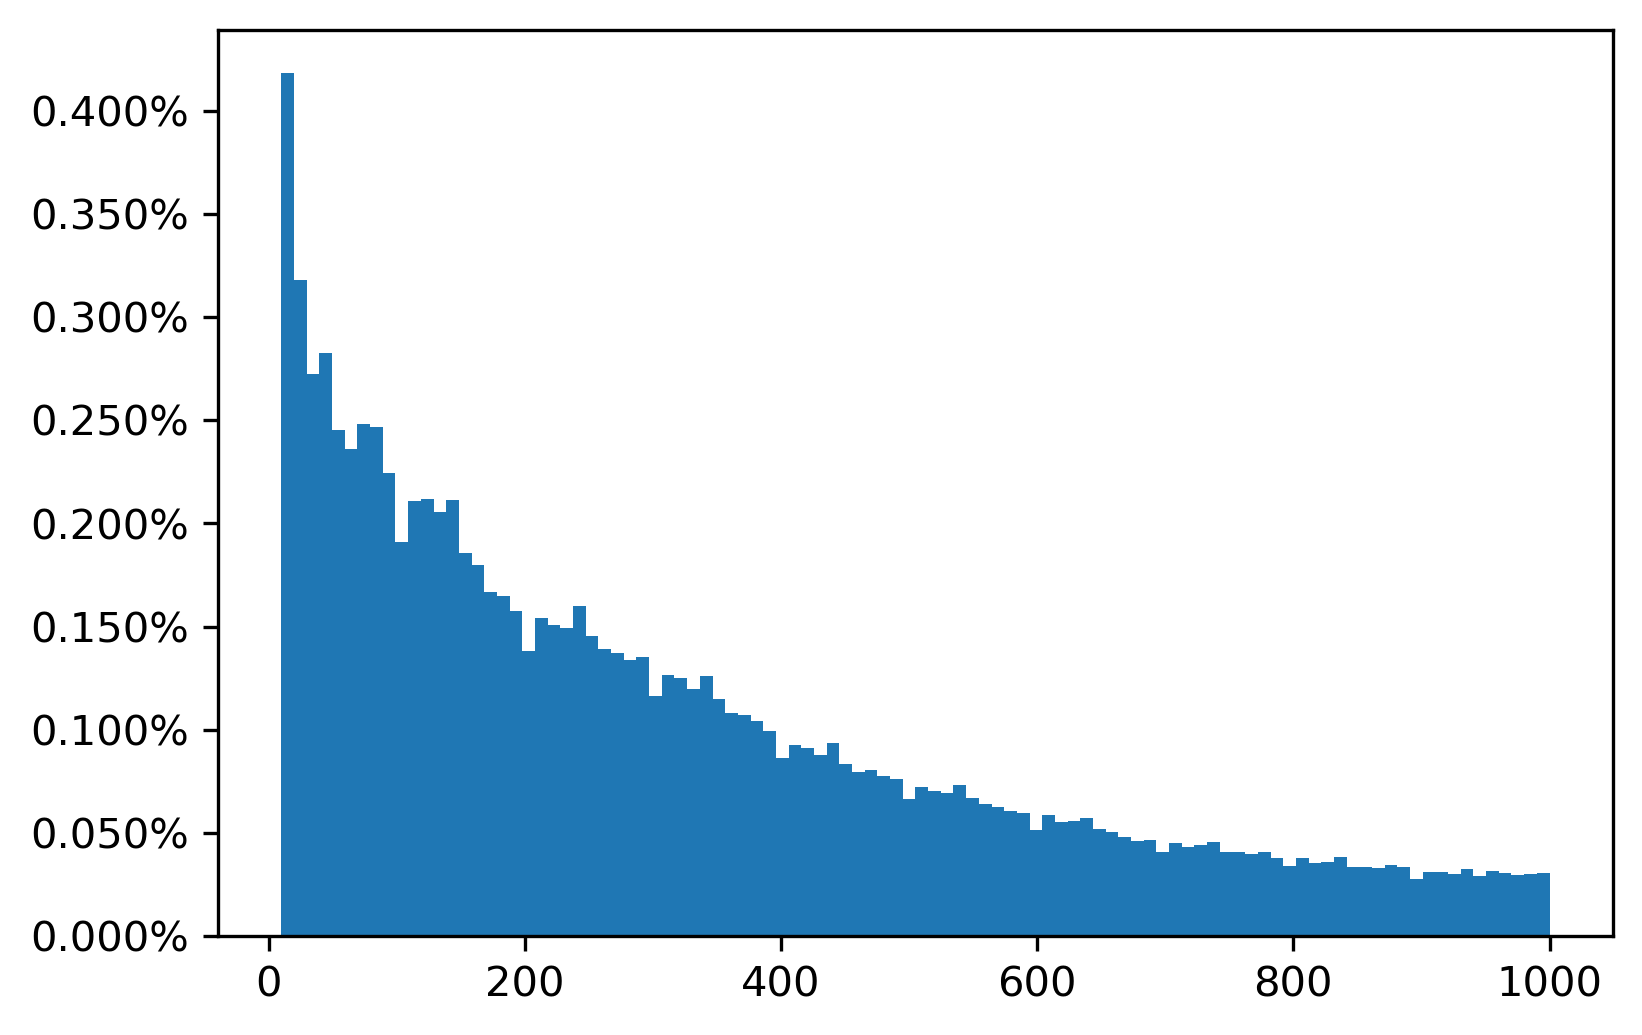

In [19]:
# 统计直方图

fig, ax = plt.subplots(dpi=300)

ax.hist(major_list,bins=100,density=True)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))

In [25]:
# 放回抽样法制造训练和测试数据

customer_type = np.zeros((customer_len,609,5))

for i in range(customer_len):
    for day in range(609):
        for j,lim in enumerate(lim_list):
            if customer_data[i][day] < lim:
                customer_type[i][day][j - 1] = 1
                break

# consume_data[sid][day] 表示 sid 这个电力供电企业在 day 天的总负载
# type_data[sid][day] 表示 sid 这个电力供电企业在 day 天的客户负载类型，最后一维表示五种用户的数量
consume_data = np.zeros((sid_max,609))
type_data = np.zeros((sid_max,609,5))

for i in range(sid_max):
    for pid in sid_list[i]:
        consume_data[i] += customer_data[pid]
        type_data[i] += customer_type[pid]


In [28]:
# 预览数据

type_data[20][51]

array([202., 194.,  57.,  31.,  16.])

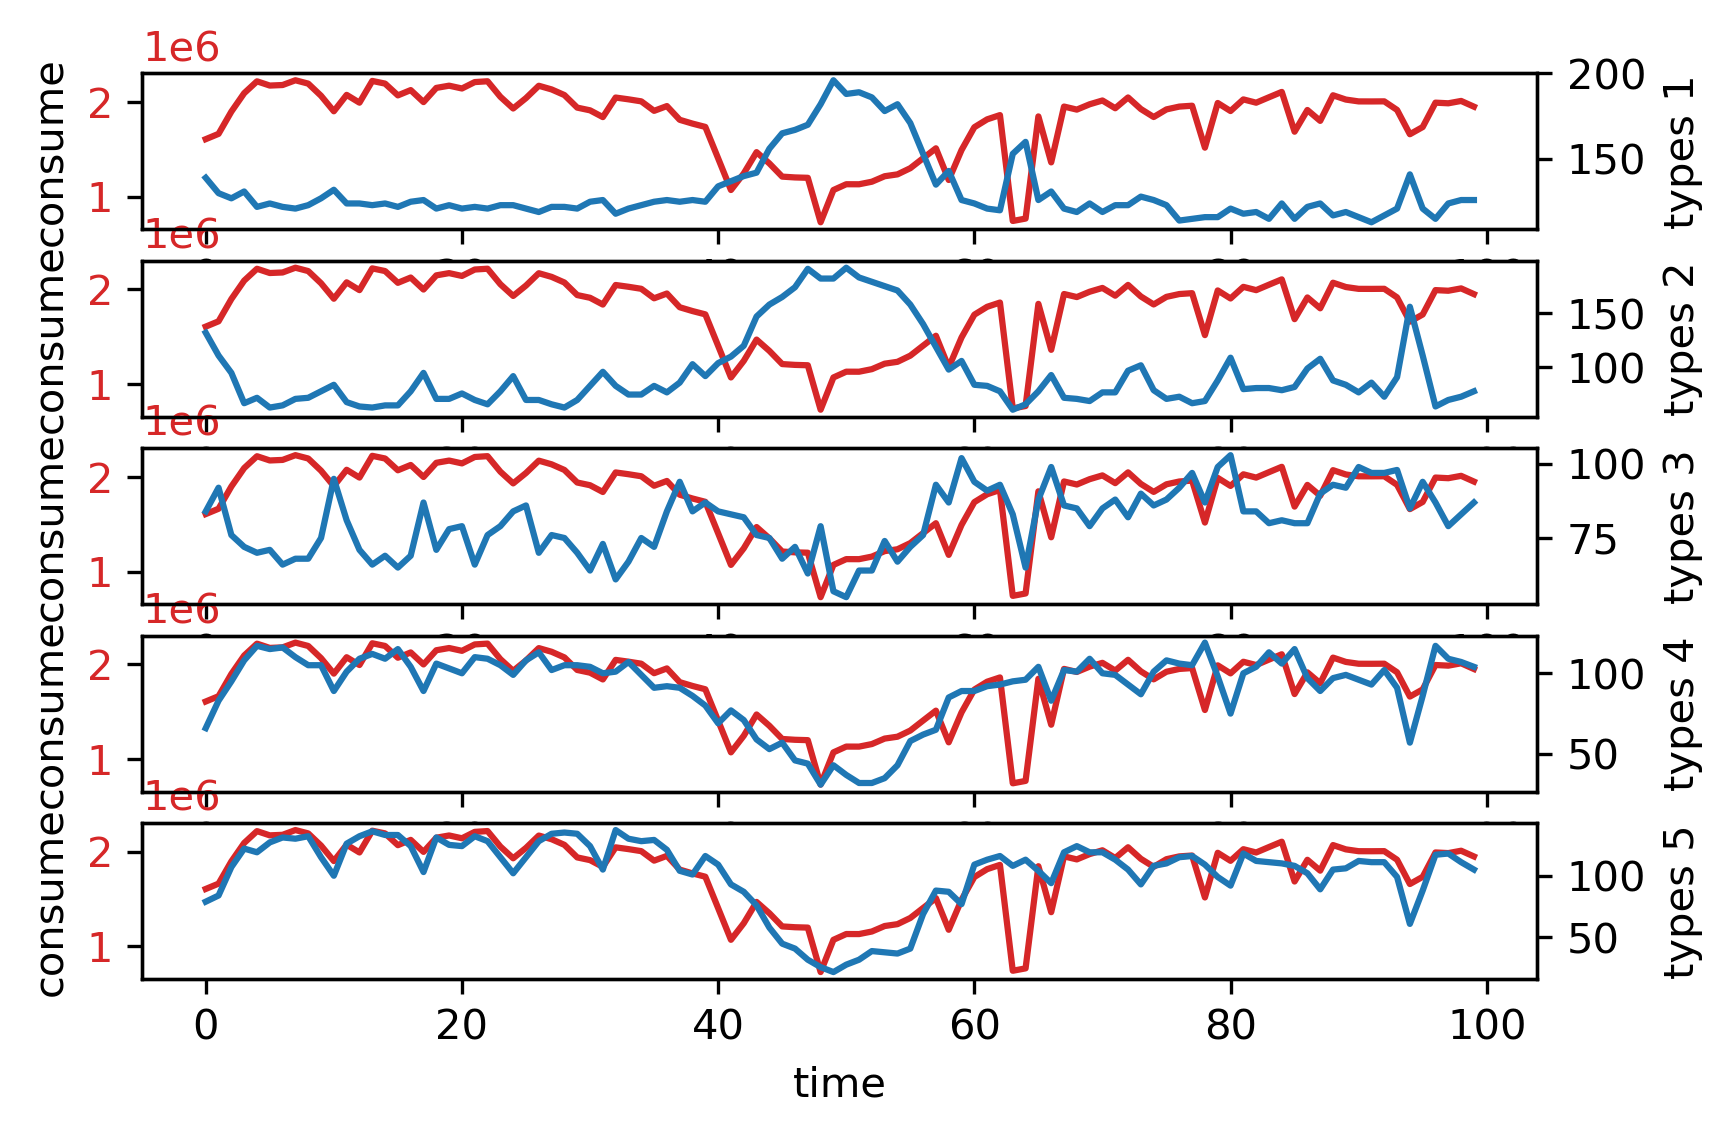

In [30]:
# 绘制图形展示高价值用户的数量、表示低价值用户的数量和总负载之间的关系，以电力供电企业 0 为例子
# 通过图形我们可以发现三者之间存在某种非线性的关系

example_id = 0
fig, axs = plt.subplots(5,1,dpi=300)
x_data = np.arange(0,100)

for i in range(0,5):
    color = 'tab:red'
    axs[i].plot(x_data, consume_data[example_id][0:100],color = color)
    axs[i].set_xlabel('time')
    axs[i].set_ylabel('consume')
    axs[i].tick_params(axis='y', labelcolor=color)

    axx = axs[i].twinx()

    axx.plot(x_data,type_data[example_id][0:100,i:i+1])
    axx.set_xlabel('time')
    axx.set_ylabel('types {}'.format(i + 1))

In [31]:
# 归一化数据

cons_mean = consume_data.mean()
cons_std = consume_data.std()

type_mean = type_data.mean()
type_std = type_data.std()

consume_data = (consume_data - cons_mean) / cons_std
type_data = (type_data - type_mean) / type_std

(cons_mean,cons_std,type_mean,type_std)

(1329767.4666161467, 735972.9753949271, 99.99988446633826, 22.634896952544953)

In [32]:
# 特别的，我们提取最后一组测试数据作为基准测试

np.save('data/consume_data_bm.npy',consume_data[-1:])
np.save('data/type_data_bm.npy',type_data[-1:])

# 保存数据，剔除基准测试数据

np.save('data/consume_data.npy',consume_data[:-1])
np.save('data/type_data.npy',type_data[:-1])